In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

# from utils import decorate
from thinkstats2 import Pmf, Cdf

import thinkstats2
import thinkplot
from datetime import datetime
import time

import statsmodels.formula.api as smf


In [2]:
games = pd.read_csv('games.csv')
gps = pd.read_csv('gps.csv')
rpe = pd.read_csv('rpe.csv')
wellness = pd.read_csv('wellness.csv')

In [3]:
games.replace('W',1,inplace=True)
games.replace('L',0,inplace=True)

In [4]:
for i, row in rpe.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    rpe.at[i,'Date'] = a1

for i, row in games.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    games.at[i,'Date'] = a1

for i, row in wellness.iterrows():
    t = datetime.strptime(row['Date'], '%Y-%m-%d')
    a1 = int(t.strftime('%Y%m%d'))
    wellness.at[i,'Date'] = a1
    
    #replacing percent strings with float percents
    wellness.at[i,'TrainingReadiness'] = float(row['TrainingReadiness'].strip('%'))

In [5]:
def standardize_col(df, col):
    
    player_grouped = df.groupby('PlayerID')
    
    for p_id in list(range(1,18)):
        mean = player_grouped.get_group(p_id)[col].mean()
        std = player_grouped.get_group(p_id)[col].std()
        for i, row in df.iterrows():
            if row['PlayerID'] == p_id:
                df.at[i, col+'_Z'] = (row[col]-mean)/std
            else:
                pass

wellness_cols = ['Fatigue', 'Soreness', 'Irritability', 'Desire', 'SleepQuality', 'TrainingReadiness']

for col in wellness_cols:
    standardize_col(wellness, col)

standardize_col(rpe,'RPE')

In [6]:
date_grouped = wellness.groupby('Date')
mean_fat = date_grouped['Fatigue_Z'].mean()
mean_sore = date_grouped['Soreness_Z'].mean()
mean_des = date_grouped['Desire_Z'].mean()
mean_irr = date_grouped['Irritability_Z'].mean()
mean_sleepq = date_grouped['SleepQuality_Z'].mean()
mean_sleept = date_grouped['SleepHours'].mean()
mean_readiness = date_grouped['TrainingReadiness_Z'].mean()

for i, row in games.iterrows():
    games.at[i, 'Fat'] = mean_fat[row['Date']]
    games.at[i, 'Sore'] = mean_sore[row['Date']]
    games.at[i, 'Des'] = mean_des[row['Date']]
    games.at[i, 'Irr'] = mean_irr[row['Date']]
    games.at[i, 'SleepQ'] = mean_sleepq[row['Date']]
    games.at[i, 'SleepT'] = mean_sleept[row['Date']]
    games.at[i, 'Readiness'] = mean_readiness[row['Date']]
    
games.head()

,GameID,Date,Tournament,TournamentGame,Team,Opponent,Outcome,TeamPoints,TeamPointsAllowed,Fat,Sore,Des,Irr,SleepQ,SleepT,Readiness
0,1,20171130,Dubai,1,Canada,Spain,1,19,0,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
1,2,20171130,Dubai,2,Canada,Ireland,1,31,0,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
2,3,20171130,Dubai,3,Canada,Fiji,1,31,14,0.494438,0.974050,1.672751,0.383781,0.079810,8.203125,0.619255
3,4,20171201,Dubai,4,Canada,France,1,24,19,-0.352514,-1.085568,1.077209,0.132107,-0.475545,7.171875,0.524882
4,5,20171201,Dubai,5,Canada,Australia,0,7,25,-0.352514,-1.085568,1.077209,0.132107,-0.475545,7.171875,0.524882


In [7]:
well2 = wellness.copy()

In [8]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403


In [9]:
rpe['SessionLoad_Z'] = rpe['Duration']*rpe['RPE_Z']

In [10]:
grouped = rpe.groupby('Date')

for i, row in rpe.iterrows():
    day = grouped.get_group(row['Date'])['SessionLoad_Z'].sum()
    rpe.at[i,'DailyLoad_Z'] = day

In [11]:
rpe.head()

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,AcuteChronicRatio,ObjectiveRating,FocusRating,BestOutOfMyself,RPE_Z,SessionLoad_Z,DailyLoad_Z
0,20180721,13,Yes,Mobility/Recovery,5.0,0.0,0.0,446.0,323.1,303.25,1.07,NaN,NaN,Not at all,-1.253472,-6.267360,76.876042
1,20180721,13,Yes,Game,29.0,7.0,203.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.153176,33.442093,76.876042
2,20180721,13,Yes,Game,27.0,9.0,243.0,NaN,NaN,NaN,NaN,NaN,NaN,Not at all,1.840789,49.701309,76.876042
3,20180720,11,Yes,Game,36.0,6.0,216.0,534.0,256.3,344.18,0.74,9.0,10.0,Absolutely,0.750374,27.013469,99.695812
4,20180720,11,Yes,Game,36.0,8.0,288.0,NaN,NaN,NaN,NaN,9.0,10.0,Absolutely,1.695403,61.034502,99.695812


In [12]:
for i, row in rpe.iterrows():
    if row['Date'] < rpe['Date'].max():
        date = row['Date']
        next_date = wellness[wellness['Date'] > date]
        print(date)
        print(next_date)
        break

20180720
        Date  PlayerID  Fatigue  Soreness  Desire  Irritability   BedTime  \
0   20180721         1        3         3       2             3  23:00:00   
1   20180721         2        4         3       4             4  23:00:00   
2   20180721         3        3         3       5             4  22:30:00   
3   20180721         4        2         3       5             4  00:30:00   
4   20180721         5        5         3       4             4  23:45:00   
5   20180721         7        2         2       5             4  22:00:00   
6   20180721        10        2         2       4             4  22:30:00   
7   20180721        11        4         3       6             4  23:00:00   
8   20180721        13        4         3       5             4  23:15:00   
9   20180721        14        3         3       4             4  22:15:00   
10  20180721        15        4         3       6             5  22:30:00   
11  20180721        16        3         2       5             3  23

In [13]:
import math

In [14]:
well_dates = wellness.groupby('Date')
columns = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z', 'USG']

for i, row in rpe.iterrows():
    if row['Date'] < rpe['Date'].max():
        date = row['Date']
        next_date = wellness[wellness['Date'] > date]['Date'].min()
        two_days = wellness[wellness['Date'] > next_date]['Date'].min()
        three_days = wellness[wellness['Date'] > two_days]['Date'].min()
        four_days = wellness[wellness['Date'] > three_days]['Date'].min()
        well_rows_next = well_dates.get_group(next_date)
        for i2, row2 in well_rows_next.iterrows():
            pid = row2['PlayerID']
            if row['PlayerID'] == pid:
                for col in columns:
                    rpe.at[i, col + '_next'] = row2[col]
        if (not math.isnan(two_days)):
            well_rows_two = well_dates.get_group(two_days)
            for i3, row3 in well_rows_two.iterrows():
                pid = row3['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        rpe.at[i, col + '_twodays'] = row3[col]
        if (not math.isnan(three_days)):
            well_rows_three = well_dates.get_group(three_days)
            for i4, row4 in well_rows_three.iterrows():
                pid = row4['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        rpe.at[i, col + '_threedays'] = row4[col]
        if (not math.isnan(four_days)):
            well_rows_four = well_dates.get_group(four_days)
            for i5, row5 in well_rows_four.iterrows():
                pid = row5['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        rpe.at[i, col + '_fourdays'] = row5[col]
#         print(date)
#         print(next_date)
#         print(two_days)
#         break

In [15]:
rpe[rpe.PlayerID == 2].head(10)

,Date,PlayerID,Training,SessionType,Duration,RPE,SessionLoad,DailyLoad,AcuteLoad,ChronicLoad,...,Desire_Z_threedays,Irritability_Z_threedays,SleepQuality_Z_threedays,USG_threedays,Fatigue_Z_fourdays,Soreness_Z_fourdays,Desire_Z_fourdays,Irritability_Z_fourdays,SleepQuality_Z_fourdays,USG_fourdays
10,20180719,2,Yes,Skills,60.0,4.0,240.0,240.0,117.1,279.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21,20180718,2,No,NaN,NaN,NaN,NaN,NaN,82.9,316.57,...,-0.121453,-0.186841,-0.10039,1.010,NaN,NaN,NaN,NaN,NaN,NaN
31,20180717,2,Yes,Skills,60.0,4.0,240.0,280.0,181.4,349.07,...,0.991322,-0.186841,-0.91068,1.017,0.207884,-0.230312,-0.121453,-0.186841,-0.10039,1.010
32,20180717,2,Yes,Mobility/Recovery,40.0,1.0,40.0,NaN,NaN,NaN,...,0.991322,-0.186841,-0.91068,1.017,0.207884,-0.230312,-0.121453,-0.186841,-0.10039,1.010
49,20180716,2,Yes,Speed,20.0,3.0,60.0,240.0,141.4,339.07,...,0.991322,-0.186841,0.70990,1.023,0.207884,0.600282,0.991322,-0.186841,-0.91068,1.017
50,20180716,2,Yes,Skills,50.0,3.0,150.0,NaN,NaN,NaN,...,0.991322,-0.186841,0.70990,1.023,0.207884,0.600282,0.991322,-0.186841,-0.91068,1.017
51,20180716,2,Yes,Mobility/Recovery,15.0,2.0,30.0,NaN,NaN,NaN,...,0.991322,-0.186841,0.70990,1.023,0.207884,0.600282,0.991322,-0.186841,-0.91068,1.017
72,20180714,2,Yes,Mobility/Recovery,30.0,2.0,60.0,60.0,247.0,404.25,...,-0.121453,-0.186841,-0.91068,1.016,1.123116,0.600282,0.991322,-0.186841,1.52019,1.022
78,20180713,2,No,NaN,NaN,NaN,NaN,NaN,238.4,402.11,...,0.991322,-0.186841,-0.91068,1.018,0.207884,0.600282,-0.121453,-0.186841,-0.91068,1.016
85,20180712,2,Yes,Speed,30.0,4.0,120.0,690.0,238.4,402.11,...,0.991322,-0.186841,1.52019,NaN,0.207884,1.430877,0.991322,-0.186841,-0.91068,1.018


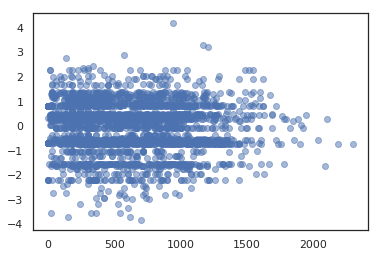

In [16]:
plt.plot(rpe.DailyLoad, rpe.Fatigue_Z_twodays, 'o', alpha=0.5)

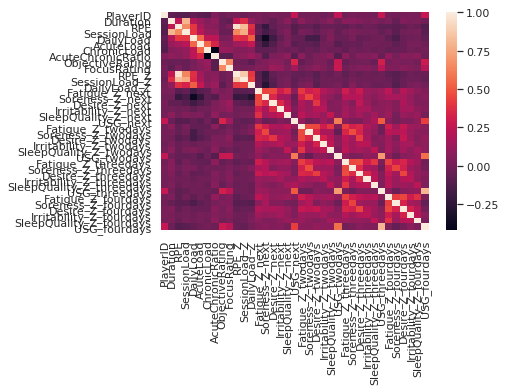

In [17]:
corr = rpe.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

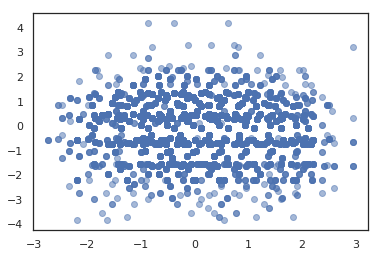

In [18]:
plt.plot(rpe.RPE_Z, rpe.Fatigue_Z_twodays, 'o', alpha=0.5)

In [30]:
rpe.columns

Index(['Date', 'PlayerID', 'Training', 'SessionType', 'Duration', 'RPE',
       'SessionLoad', 'DailyLoad', 'AcuteLoad', 'ChronicLoad',
       'AcuteChronicRatio', 'ObjectiveRating', 'FocusRating',
       'BestOutOfMyself', 'RPE_Z', 'SessionLoad_Z', 'DailyLoad_Z',
       'Fatigue_Z_next', 'Soreness_Z_next', 'Desire_Z_next',
       'Irritability_Z_next', 'SleepQuality_Z_next', 'USG_next',
       'Fatigue_Z_twodays', 'Soreness_Z_twodays', 'Desire_Z_twodays',
       'Irritability_Z_twodays', 'SleepQuality_Z_twodays', 'USG_twodays',
       'Fatigue_Z_threedays', 'Soreness_Z_threedays', 'Desire_Z_threedays',
       'Irritability_Z_threedays', 'SleepQuality_Z_threedays', 'USG_threedays',
       'Fatigue_Z_fourdays', 'Soreness_Z_fourdays', 'Desire_Z_fourdays',
       'Irritability_Z_fourdays', 'SleepQuality_Z_fourdays', 'USG_fourdays'],
      dtype='object')

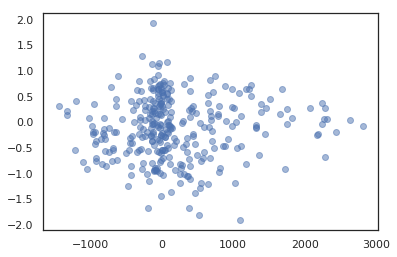

In [42]:
grouped = rpe.groupby('DailyLoad_Z')
fatigue_by_sleepqual = grouped['Soreness_Z_twodays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

In [40]:
formula = 'Fatigue_Z_threedays ~ DailyLoad_Z'
results = smf.ols(formula,data=rpe).fit()
results.params

Intercept     -0.031426
DailyLoad_Z   -0.000051
dtype: float64

In [19]:
well2 = wellness.copy()

In [20]:
well_dates = well2.groupby('Date')
columns = ['Fatigue_Z', 'Soreness_Z', 'Desire_Z', 'Irritability_Z',
           'SleepQuality_Z', 'USG']

for i, row in well2.iterrows():
    if row['Date'] < well2['Date'].max():
        date = row['Date']
        next_date = well2[well2['Date'] > date]['Date'].min()
        two_days = well2[well2['Date'] > next_date]['Date'].min()
        three_days = well2[well2['Date'] > two_days]['Date'].min()
        well_rows_next = well_dates.get_group(next_date)
        for i2, row2 in well_rows_next.iterrows():
            pid = row2['PlayerID']
            if row['PlayerID'] == pid:
                for col in columns:
                    well2.at[i, col + '_next'] = row2[col]
        if (not math.isnan(two_days)):
            well_rows_two = well_dates.get_group(two_days)
            for i3, row3 in well_rows_two.iterrows():
                pid = row3['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        well2.at[i, col + '_twodays'] = row3[col]
        if (not math.isnan(three_days)):
            well_rows_three = well_dates.get_group(three_days)
            for i4, row4 in well_rows_three.iterrows():
                pid = row4['PlayerID']
                if row['PlayerID'] == pid:
                    for col in columns:
                        well2.at[i, col + '_threedays'] = row4[col]

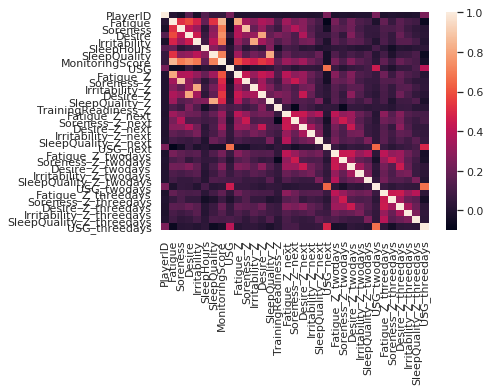

In [21]:
corr = well2.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

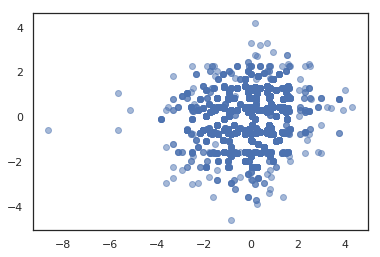

In [22]:
plt.plot(well2.SleepQuality_Z, well2.Fatigue_Z_twodays, 'o', alpha=0.5)

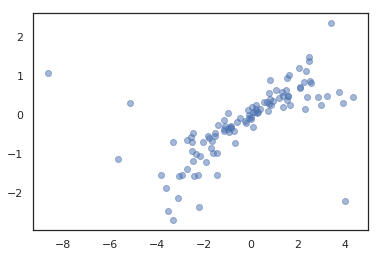

In [55]:
grouped = well2.groupby('SleepQuality_Z')
fatigue_by_sleepqual = grouped['Fatigue_Z'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

In [56]:
formula = 'Fatigue_Z ~ SleepQuality_Z'
results = smf.ols(formula,data=well2).fit()
results.params

Intercept        -5.898060e-17
SleepQuality_Z    3.871889e-01
dtype: float64

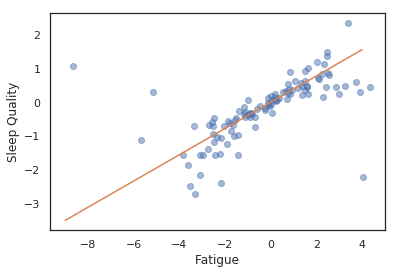

In [57]:
df = pd.DataFrame()
df['SleepQuality_Z'] = np.linspace(-9,4)
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)
pred = results.predict(df)
plt.plot(df['SleepQuality_Z'], pred)
plt.xlabel('Fatigue')
plt.ylabel('Sleep Quality')
plt.show()

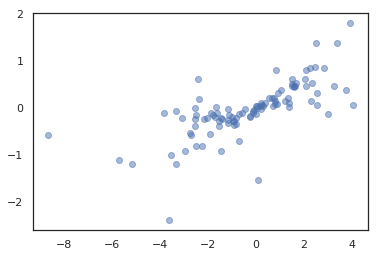

In [49]:
grouped = well2.groupby('SleepQuality_Z')
fatigue_by_sleepqual = grouped['Fatigue_Z_next'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

In [50]:
formula = 'Fatigue_Z_next ~ SleepQuality_Z'
results = smf.ols(formula,data=well2).fit()
results.params

Intercept        -0.001953
SleepQuality_Z    0.221766
dtype: float64

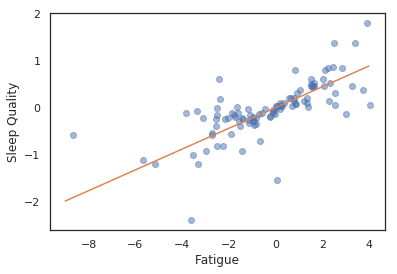

In [51]:
df = pd.DataFrame()
df['SleepQuality_Z'] = np.linspace(-9,4)
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)
pred = results.predict(df)
plt.plot(df['SleepQuality_Z'], pred)
plt.xlabel('Fatigue')
plt.ylabel('Sleep Quality')
plt.show()

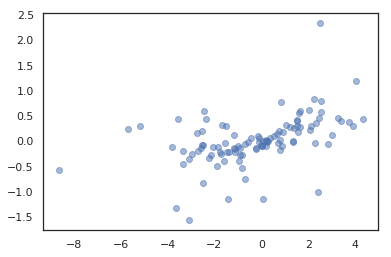

In [52]:
grouped = well2.groupby('SleepQuality_Z')
fatigue_by_sleepqual = grouped['Fatigue_Z_twodays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

In [53]:
formula = 'Fatigue_Z_twodays ~ SleepQuality_Z'
results = smf.ols(formula,data=well2).fit()
results.params

Intercept        -0.006315
SleepQuality_Z    0.149236
dtype: float64

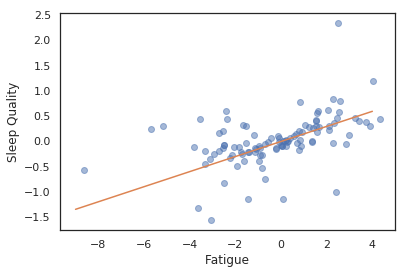

In [54]:
df = pd.DataFrame()
df['SleepQuality_Z'] = np.linspace(-9,4)
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)
pred = results.predict(df)
plt.plot(df['SleepQuality_Z'], pred)
plt.xlabel('Fatigue')
plt.ylabel('Sleep Quality')
plt.show()

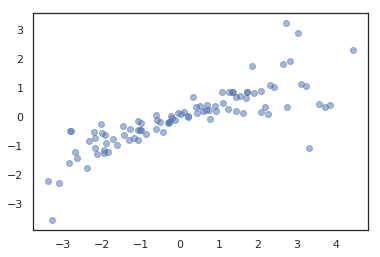

In [59]:
grouped = well2.groupby('Soreness_Z')
fatigue_by_sleepqual = grouped['Fatigue_Z'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

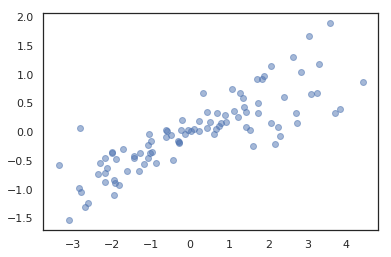

In [60]:
grouped = well2.groupby('Soreness_Z')
fatigue_by_sleepqual = grouped['Fatigue_Z_next'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

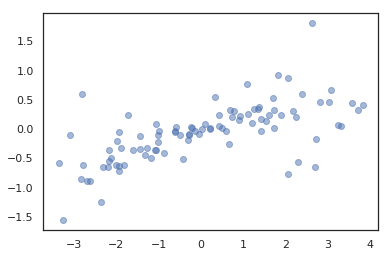

In [61]:
grouped = well2.groupby('Soreness_Z')
fatigue_by_sleepqual = grouped['Fatigue_Z_twodays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

In [64]:
well2.columns

Index(['Date', 'PlayerID', 'Fatigue', 'Soreness', 'Desire', 'Irritability',
       'BedTime', 'WakeTime', 'SleepHours', 'SleepQuality', 'MonitoringScore',
       'Pain', 'Illness', 'Menstruation', 'Nutrition', 'NutritionAdjustment',
       'USGMeasurement', 'USG', 'TrainingReadiness', 'Fatigue_Z', 'Soreness_Z',
       'Irritability_Z', 'Desire_Z', 'SleepQuality_Z', 'TrainingReadiness_Z',
       'Fatigue_Z_next', 'Soreness_Z_next', 'Desire_Z_next',
       'Irritability_Z_next', 'SleepQuality_Z_next', 'USG_next',
       'Fatigue_Z_twodays', 'Soreness_Z_twodays', 'Desire_Z_twodays',
       'Irritability_Z_twodays', 'SleepQuality_Z_twodays', 'USG_twodays',
       'Fatigue_Z_threedays', 'Soreness_Z_threedays', 'Desire_Z_threedays',
       'Irritability_Z_threedays', 'SleepQuality_Z_threedays',
       'USG_threedays'],
      dtype='object')

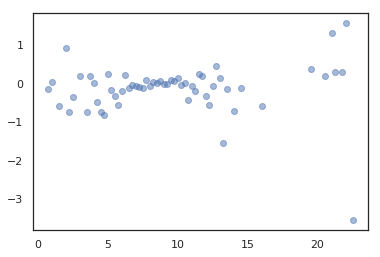

In [65]:
grouped = well2.groupby('SleepHours')
fatigue_by_sleepqual = grouped['Fatigue_Z_twodays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

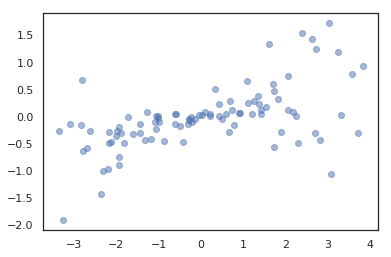

In [66]:
grouped = well2.groupby('Soreness_Z')
fatigue_by_sleepqual = grouped['Soreness_Z_twodays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

In [68]:
game2 = games[['GameID', 'Date']].copy()
gps = pd.merge(game2,gps, on=['GameID'])

In [69]:
hits = pd.DataFrame()
# df['GameID'] = gps['GameID']    
hits['PlayerID'] = gps['PlayerID']
hits['Date'] = gps['Date']

# df = df.drop_duplicates(subset=['GameID', 'PlayerID', 'Date'], keep='first')
hits = hits.drop_duplicates(subset=['PlayerID', 'Date'], keep='first')

hits['hits'] = 0

for i, row in hits.iterrows():
    p1 = gps[gps.PlayerID == row.PlayerID]
    p1 = p1[p1.Date == row.Date]
    hit = len(p1[p1.AccelImpulse > 5.8])
    hits.at[i, 'hits'] = hit

In [71]:
x = pd.merge(hits, well2, on=['PlayerID', 'Date'])

In [72]:
x.head()

,PlayerID,Date,hits,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,...,Desire_Z_twodays,Irritability_Z_twodays,SleepQuality_Z_twodays,USG_twodays,Fatigue_Z_threedays,Soreness_Z_threedays,Desire_Z_threedays,Irritability_Z_threedays,SleepQuality_Z_threedays,USG_threedays
0,2,20171130,87,4,4,5,4,21:15:00,06:00:00,8.75,...,NaN,NaN,NaN,NaN,0.207884,-1.060907,-1.234229,-0.186841,-0.100390,NaN
1,3,20171130,50,5,4,6,4,21:30:00,05:30:00,8.00,...,0.757503,0.143069,-2.711368,NaN,-0.578512,-0.279482,-0.629923,0.143069,-2.711368,NaN
2,4,20171130,77,3,6,6,5,01:00:00,07:15:00,6.25,...,-2.863271,-0.940299,-0.707157,NaN,-0.374305,0.507847,0.095762,0.463336,0.774277,NaN
3,6,20171130,48,4,4,4,4,22:00:00,07:15:00,9.25,...,0.126636,0.145116,0.022630,NaN,-1.012796,-0.609797,0.126636,0.145116,1.212985,NaN
4,7,20171130,50,5,4,6,4,21:00:00,06:00:00,9.00,...,-1.365070,-1.334150,-1.150014,NaN,-1.544021,-1.613439,-3.073898,-1.334150,0.187121,NaN


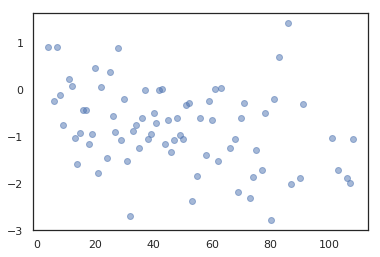

In [75]:
grouped = x.groupby('hits')
fatigue_by_sleepqual = grouped['Soreness_Z_next'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

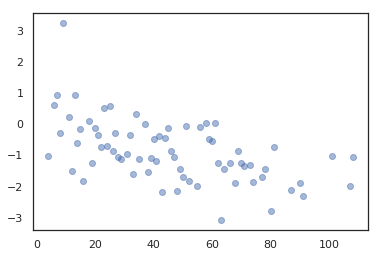

In [76]:
grouped = x.groupby('hits')
fatigue_by_sleepqual = grouped['Soreness_Z_twodays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

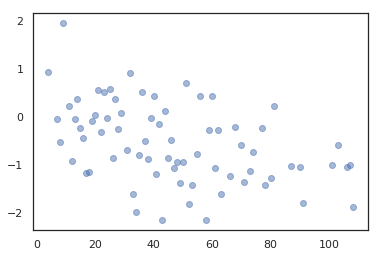

In [77]:
grouped = x.groupby('hits')
fatigue_by_sleepqual = grouped['Soreness_Z_threedays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

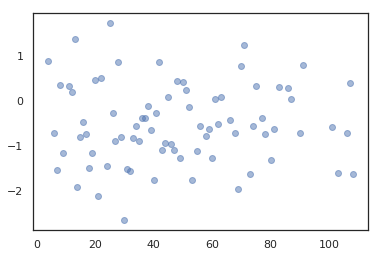

In [78]:
grouped = x.groupby('hits')
fatigue_by_sleepqual = grouped['Fatigue_Z_next'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

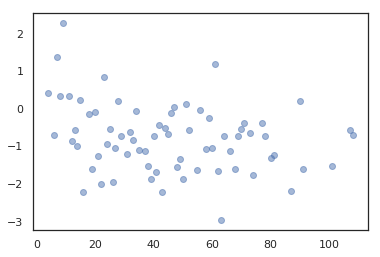

In [79]:
grouped = x.groupby('hits')
fatigue_by_sleepqual = grouped['Fatigue_Z_twodays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

In [80]:
x.columns

Index(['PlayerID', 'Date', 'hits', 'Fatigue', 'Soreness', 'Desire',
       'Irritability', 'BedTime', 'WakeTime', 'SleepHours', 'SleepQuality',
       'MonitoringScore', 'Pain', 'Illness', 'Menstruation', 'Nutrition',
       'NutritionAdjustment', 'USGMeasurement', 'USG', 'TrainingReadiness',
       'Fatigue_Z', 'Soreness_Z', 'Irritability_Z', 'Desire_Z',
       'SleepQuality_Z', 'TrainingReadiness_Z', 'Fatigue_Z_next',
       'Soreness_Z_next', 'Desire_Z_next', 'Irritability_Z_next',
       'SleepQuality_Z_next', 'USG_next', 'Fatigue_Z_twodays',
       'Soreness_Z_twodays', 'Desire_Z_twodays', 'Irritability_Z_twodays',
       'SleepQuality_Z_twodays', 'USG_twodays', 'Fatigue_Z_threedays',
       'Soreness_Z_threedays', 'Desire_Z_threedays',
       'Irritability_Z_threedays', 'SleepQuality_Z_threedays',
       'USG_threedays'],
      dtype='object')

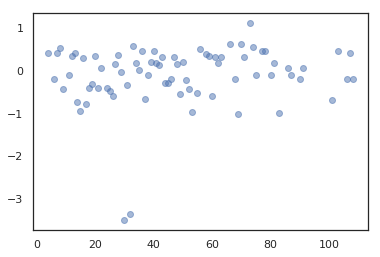

In [83]:
grouped = x.groupby('hits')
fatigue_by_sleepqual = grouped['Irritability_Z_next'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

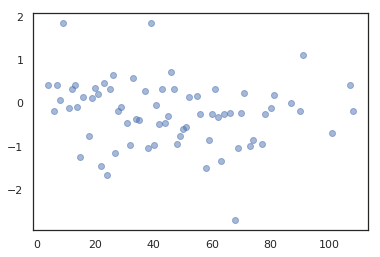

In [84]:
grouped = x.groupby('hits')
fatigue_by_sleepqual = grouped['Irritability_Z_twodays'].mean()
plt.plot(fatigue_by_sleepqual, 'o', alpha=0.5)

In [89]:
formula = 'Soreness_Z_twodays ~ hits'
results = smf.ols(formula,data=x).fit()
results.params

Intercept   -0.121375
hits        -0.016980
dtype: float64

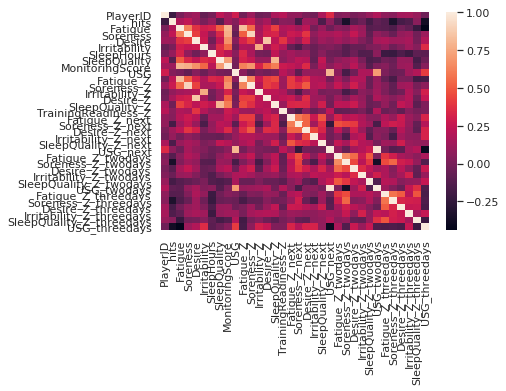

In [90]:
corr = x.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)